In [1]:
'''
This notebook is used to create the final expenses dataset, it uses the following steps:
1. Load the cleaned expenses dataset
2. Download the BERT model that is a sentence-transformer model
3. Create the embeddings for the expenses dataset
4. Split the data into train and test
5. Create embeddings with the BERT model for the train data
6. Using cosine similarity, find the most similar description for each expense in the train data against the test data
7. Merge the train and test data
8. Fix some of the categories if possible
'''

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-mpnet-base-v2') 

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import re

# Make all categories using BERT
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

#for plotting expense categories later
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker # for formatting major units on x-y axis



#for finding most similar text vectors
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vedaantibaliga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Get pre-processed data
df = pd.read_csv("pre_processed_data.csv")

In [4]:
# Make training data for BERT, if 'Transaction Category' is not null then it is a training example
df_train = df[df['Transaction Category'].notnull()]
df_test = df[df['Transaction Category'].isnull()]

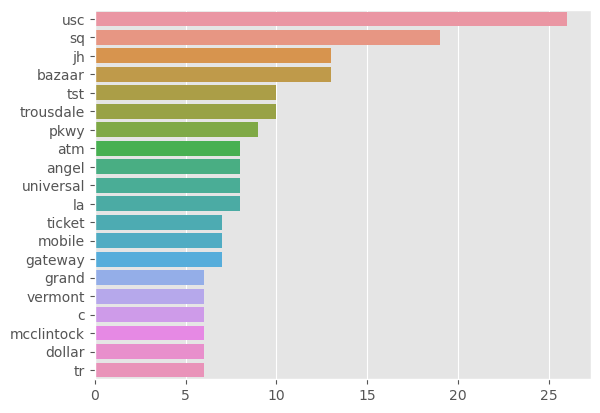

In [29]:
def plot_top_words(text, top_n=20):
    top_20 = Counter(" ".join(text).split()).most_common(20)
    x,y = zip(*top_20)
    sns.barplot(x=list(y),y=list(x))

plot_top_words(df_test['Description'])

In [5]:
df_train['Transaction Category'].value_counts()

Shopping & Groceries    347
Food & Dining            80
Transportation           44
Tuition & Rent           21
Laundry                  21
Recreation                3
Miscellaneous             1
Name: Transaction Category, dtype: int64

In [6]:
### Download pre-trained BERT model

bert_input = df_train['Description'].tolist()
embeddings = model.encode(bert_input, show_progress_bar = True)
embedding_BERT = np.array(embeddings)

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [7]:
# see what it has produced
df_embedding_BERT = pd.DataFrame(embeddings)
df_embedding_BERT.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.007730,0.038054,-0.003887,-0.019954,0.007670,-0.049701,0.022099,0.002901,0.064461,0.057569,...,0.119259,-0.111363,-0.162326,0.052900,0.000631,0.186841,-0.020295,0.203958,-0.105490,-0.093788
1,-0.263091,0.194230,-0.021180,0.230724,0.013007,-0.007707,-0.076808,0.095086,-0.254884,0.032480,...,0.152419,-0.098562,0.000696,0.015956,-0.061621,0.075770,-0.036174,0.052006,0.080220,-0.065025
2,-0.051970,-0.078912,0.000096,0.040493,0.164213,0.070451,0.165698,-0.082789,-0.206253,-0.078708,...,0.014682,-0.021122,-0.175895,-0.028958,-0.020924,0.304364,-0.113344,0.127074,0.037624,-0.024135
3,0.007730,0.038054,-0.003887,-0.019954,0.007670,-0.049701,0.022099,0.002901,0.064461,0.057569,...,0.119259,-0.111363,-0.162326,0.052900,0.000631,0.186841,-0.020295,0.203958,-0.105490,-0.093788
4,-0.269139,0.238847,-0.150048,0.214777,0.018937,-0.061374,-0.078618,0.147039,0.113104,0.093514,...,0.099323,-0.073299,-0.138753,0.050173,-0.015268,0.064129,-0.092566,0.092582,0.014063,-0.106882


In [8]:
# Apply BERT embedding
bert_input_test = df_test['Description'].tolist()
embeddings_test = model.encode(bert_input_test, show_progress_bar = True)
embedding_BERT_test = np.array(embeddings_test)

df_embedding_bert_test = pd.DataFrame(embeddings_test)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
# Pair test data with most similar training data
# Find the most similar word embedding with unseen data in the training data

similarity_new_data = cosine_similarity(embedding_BERT_test, embedding_BERT)
similarity_df = pd.DataFrame(similarity_new_data)

# Returns index for most similar embedding
# See first column of the output dataframe below
index_similarity = similarity_df.idxmax(axis = 1)

# Return dataframe for most similar embedding/transactions in training dataframe
data_inspect = df_train.iloc[index_similarity, :].reset_index(drop=True)

In [10]:
test_df = df_test['Description'].reset_index()
unseen_verbatim = test_df['Description']
indexes = test_df['index']
matched_verbatim = data_inspect['Description']
annotation = data_inspect['Transaction Category']

d_output = {
            'unseen_transaction': unseen_verbatim,
            'matched_transaction': matched_verbatim, 
            'matched_class': annotation,
            'index_for_matched_transaction': indexes
            
            }

In [11]:
result_df = pd.DataFrame(d_output)
result_df

,unseen_transaction,matched_transaction,matched_class,index_for_matched_transaction
0,cmsvendusc grand,ach univ cal payment univ cal name,Tuition & Rent,147
1,cmsvendusc grand,ach univ cal payment univ cal name,Tuition & Rent,150
2,cmsvendusc grand,ach univ cal payment univ cal name,Tuition & Rent,151
3,k speed torrance vermont torr,venmo shein parkway,Shopping & Groceries,160
4,k speed torrance padd vermont,supercuts vermont c,Recreation,161
...,...,...,...,...
164,jh bazaar vermont c,trader jo trader joes,Shopping & Groceries,681
165,jh bazaar vermont c,trader jo trader joes,Shopping & Groceries,682
166,dollar tr pico,doordashpapa johns pi streetsuite,Food & Dining,683
167,cava grill usc village,chipotle santa monica blv beve,Food & Dining,684


In [12]:
# join on index to get the category for the test data
final_df = df.join(result_df.set_index('index_for_matched_transaction'))
final_df.drop(['matched_transaction','unseen_transaction'], axis=1, inplace=True)

In [13]:
final_df["Transaction Category"].fillna(final_df["matched_class"], inplace = True)
final_df.drop(['matched_class'], axis=1, inplace=True)

## Let's check the categories in test data and try to fix them if any

In [14]:
final_df

,Posting Date,Transaction Type,Amount,Description,Transaction Category
0,4/25/2023,Debit,-19.00,target hoove,Shopping & Groceries
1,4/24/2023,Debit,-29.31,dominos angel,Food & Dining
2,4/20/2023,Debit,-6.18,target store,Shopping & Groceries
3,4/11/2023,Debit,-8.95,target hoove,Shopping & Groceries
4,4/11/2023,Debit,-17.49,dominos,Food & Dining
...,...,...,...,...,...
681,8/13/2021,Debit,-26.46,jh bazaar vermont c,Shopping & Groceries
682,8/13/2021,Debit,-33.94,jh bazaar vermont c,Shopping & Groceries
683,8/12/2021,Debit,-18.62,dollar tr pico,Food & Dining
684,8/12/2021,Debit,-11.68,cava grill usc village,Food & Dining


In [15]:
final_df.value_counts('Transaction Category')

Transaction Category
Shopping & Groceries    415
Food & Dining           160
Transportation           48
Tuition & Rent           29
Laundry                  27
Recreation                5
Miscellaneous             2
dtype: int64

In [16]:
# Make a function for rechecking if the category is correct
def check_if_cat_correct(df,category_name):
    return df[df['Transaction Category'] == category_name]['Description'].unique()

### Miscellaneous

In [17]:
check_if_cat_correct(final_df,'Miscellaneous')

array([' fedex airways  memphis ', ' emirates e   fl new york   ticket'],
      dtype=object)

### Recreation

In [18]:
check_if_cat_correct(final_df,'Recreation')

array([' supercuts vermont    c ',
       '   bath body works glendale galleria glendale ',
       ' k speed torrance padd vermont  ',
       ' k speed torrance supe vermont  '], dtype=object)

### Laundry

In [19]:
check_if_cat_correct(final_df,'Laundry')

array([' disneyland tickets harbor  ', ' wash laundry kiosk   torranc ',
       ' wash kiosk mobile    dieg ',
       ' usc ticket officereta trousdale pkwy ',
       ' polo factory store com citadel drive c ',
       ' athena parking hill    c ', '   artisan imports  diego   diego ',
       ' wash kiosk mobile    diego ',
       ' wash kiosk mobile n pacific coast hwy '], dtype=object)

### Tuition & Rent

In [20]:
check_if_cat_correct(final_df,'Tuition & Rent') 

array([' cmsvendusc grand    ', ' ach univ cal  payment  univ cal name ',
       ' uscis massachusetts  ',
       ' atm atm usc credit union mcclintock    ',
       ' overdrawn amount univ cal', ' intl education bristol pkwy ',
       ' ach univ cal  payment  univ cal', ' usc student health ser    '],
      dtype=object)

### Transportation

In [21]:
check_if_cat_correct(final_df,'Transportation') 

array([' venmo uber  parkway ', ' tst thai trio   l ',
       ' lyft ride mon berry   ', ' lyft ride market   ',
       ' lyft ride berry   ', ' lyft ride tue pm berry   ',
       ' lyft ride thu pm berry   ', ' sixt rent car   street  angel ',
       ' venmo uber  merchandse mrt pl ', ' lyft rides berry   ',
       ' lyft cancel fee berry   ', ' vfs services usa inc wilshire  ',
       ' venmo lyft inc  merchandse mrt pl ',
       ' lyft lyft rentals berry street  fr ',
       ' tst better sex melrose  lo '], dtype=object)

### Food & Dining

In [22]:
check_if_cat_correct(final_df,'Food & Dining') 

array([' dominos    angel ', ' dominos   ',
       ' starbucks store e colorado  ', ' subway     ',
       ' starbucks store   l ', ' chipotle santa monica blv beve ',
       ' subway  street  ', ' doordashpapa johns pi  streetsuite ',
       ' doordashburger king  streetsuite ', ' chickfila    ',
       '  doordash dashmart  street ', '  doordash pandaexpr  street ',
       '  doordash californi  street ', ' herff jones   street ',
       ' usc trojans housing ap    ', '  doordash kfc  street ',
       '  doordash mcdonalds  street ', '  doordash thedollyl  street ',
       ' sulekha bch  bldg c ', ' ic   downtow wilshire  l ',
       ' ddf dxb  dubai dubai ae ',
       ' mcdonaldsdxb airport dubai intl airport ',
       ' venmo doordash  parkway ',
       ' sp alphaleteus summer park drive sta ',
       ' sq rice balls fire ballinger  ', ' tst fratelli cafe melrose   ',
       ' northern cafe   str  ', ' link scooters hamilton  cambridge ',
       '   circle k   ', '   safety park be

### Shopping & Groceries

In [23]:
check_if_cat_correct(final_df,'Shopping & Groceries') 

array(['   target  hoove   ', '   target store      ',
       ' amazon primehyorl terry  n amz ',
       ' amazon primehdsvxc terry  n amz ',
       ' amazon primeiulip terry  n amz ',
       ' amazon primefkadih terry  n amz ', '   gap outlet us commerce ',
       '   walgreens hollywo   ', '   marshalls firestone   gate ',
       '   walmart firestone   gate ', '   panda express universal cit ',
       ' amazon primeprel terry  n amz ', '   target store     ',
       ' amazon primeqhgq terry  n amz ',
       ' amazon primeeri terry  n amz ',
       'recurring  amazon primeivpma terry  n amz ',
       '   target store   unit   ',
       ' napa farms market tg sfo intl terarea g ', '   nordstrom  rd   ',
       '   target     ', '   trader jo trader joes   ',
       ' venmo  street new york  ', ' ralphs vermont   angele ',
       ' venmo shein  parkway ', '   amazoncomhjwpwq seattle ',
       '   amazoncomhjxibc seattle ', '   amazoncomhjzgn seattle ',
       ' k speed torrance vermont

### Fix some of the categories

In [24]:
final_df.loc[final_df['Transaction Category'] == 'Miscellaneous']

,Posting Date,Transaction Type,Amount,Description,Transaction Category
102,1/19/2022,Debit,-9.80,fedex airways memphis,Miscellaneous
275,11/18/2022,Debit,-173.41,emirates e fl new york ticket,Miscellaneous


In [25]:
# shift this to Transportation
final_df.at[275,"Transaction Category"] = "Transportation"

In [45]:
# shift Laundry transactions to Recreation
for i in ["disneyland tickets harbor","usc ticket officereta trousdale pkwy","polo factory store com citadel drive c","athena parking hill    c","artisan imports  diego   diego ","regal","cinema"]:
    final_df.loc[final_df['Description'].str.contains(re.escape(i), case=False),'Transaction Category'] = 'Recreation'

In [27]:
for i in ["mint"]:
    final_df.loc[final_df['Description'].str.contains(re.escape(i), case=False),'Transaction Category'] = 'Miscellaneous'

In [46]:
final_df.head()

,Posting Date,Transaction Type,Amount,Description,Transaction Category
0,4/25/2023,Debit,19.00,target hoove,Shopping & Groceries
1,4/24/2023,Debit,29.31,dominos angel,Food & Dining
2,4/20/2023,Debit,6.18,target store,Shopping & Groceries
3,4/11/2023,Debit,8.95,target hoove,Shopping & Groceries
4,4/11/2023,Debit,17.49,dominos,Food & Dining


In [41]:
# Add an amount for tuition from an external source
new_entry = {'Posting Date': '1/4/2023', 'Transaction Type' : 'Debit','Amount': 19882.08,'Description': 'ach univ of so cal','Transaction Category': 'Tuition & Rent'}
final_df = pd.concat([final_df, pd.DataFrame([new_entry])], ignore_index=True)

In [36]:
# convert "Amount" to positive
final_df['Amount'] = final_df['Amount'].abs()

In [48]:
final_df["Transaction Category"].value_counts()

Shopping & Groceries    407
Food & Dining           160
Transportation           49
Tuition & Rent           30
Laundry                  21
Recreation               16
Miscellaneous             4
Name: Transaction Category, dtype: int64

In [49]:
final_df.to_csv("Expenses_v3.csv", index=False)

## References
https://towardsdatascience.com/categorize-free-text-bank-transaction-descriptions-using-bert-44c9cc87735b